In [0]:
from google.colab.patches import cv2_imshow
import os
import pathlib
import cv2
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd

In [0]:
new_dir_train = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/train'
new_dir_test = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/test'
new_dir_val = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/val'

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      fill_mode='nearest'
      )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        new_dir_train,  # This is the source directory for training images
        target_size=(200,200),
        batch_size=66,
        color_mode = 'grayscale',          
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        new_dir_val,  # This is the source directory for training images
        target_size=(200,200),  
        batch_size=20,
        color_mode = 'grayscale',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        new_dir_test,  # This is the source directory for training images
        target_size=(200,200),  
        batch_size=10,
        color_mode = 'grayscale',
        class_mode='categorical')

Found 660 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 149 images belonging to 7 classes.


In [0]:
inputs = tf.keras.layers.Input(shape=(200,200, 1))
x = tf.keras.layers.Conv2D(32, 5, strides = 2, padding='valid')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x)
x = tf.keras.layers.LayerNormalization()(x)
#parallel featext block1
#path1
x_1 = tf.keras.layers.Conv2D(64, 5, strides = 2, padding='valid')(x)
x_1 = tf.keras.layers.Activation('relu')(x_1)

x_1 = tf.keras.layers.Conv2D(128, 3, strides = 1, padding='same')(x_1)
x_1 = tf.keras.layers.Activation('relu')(x_1)

# x_1 = tf.keras.layers.Conv2D(128, 1, strides = 1, padding='valid')(x_1)
# x_1 = tf.keras.layers.Activation('relu')(x_1)

# x_1 = tf.keras.layers.Conv2D(256,1,strides=1,padding='same')(x_1)
# x_1 = tf.keras.layers.Activation('relu')(x_1)
#path2
x_2 = tf.keras.layers.Conv2D(32, 3, strides = 2, padding='same')(x)
x_2 = tf.keras.layers.Activation('relu')(x_2)

x_2 = tf.keras.layers.Conv2D(64, 3, strides = 1, padding='valid')(x_2)
x_2 = tf.keras.layers.Activation('relu')(x_2)

x_2 = tf.keras.layers.Conv2D(128, 1, strides = 1, padding='valid')(x_2)
x_2 = tf.keras.layers.Activation('relu')(x_2)

#concatenate
x_3 = tf.keras.layers.Concatenate(axis = 3)([x_1, x_2])
x_3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x_3)

x_3 = tf.keras.layers.Flatten()(x_3)
#x_3 = tf.keras.layers.Dense(128,activation='relu')(x_3)
x_3 =tf.keras.layers.Dropout(0.5)(x_3)
x_4 = tf.keras.layers.Dense(7)(x_3)
x_5 = tf.keras.layers.Activation('softmax')(x_4)

In [0]:
model = tf.keras.models.Model(inputs = inputs , outputs = x_5)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 98, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 98, 98, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 32)   0           activation[0][0]                 
______________________________________________________________________________________________

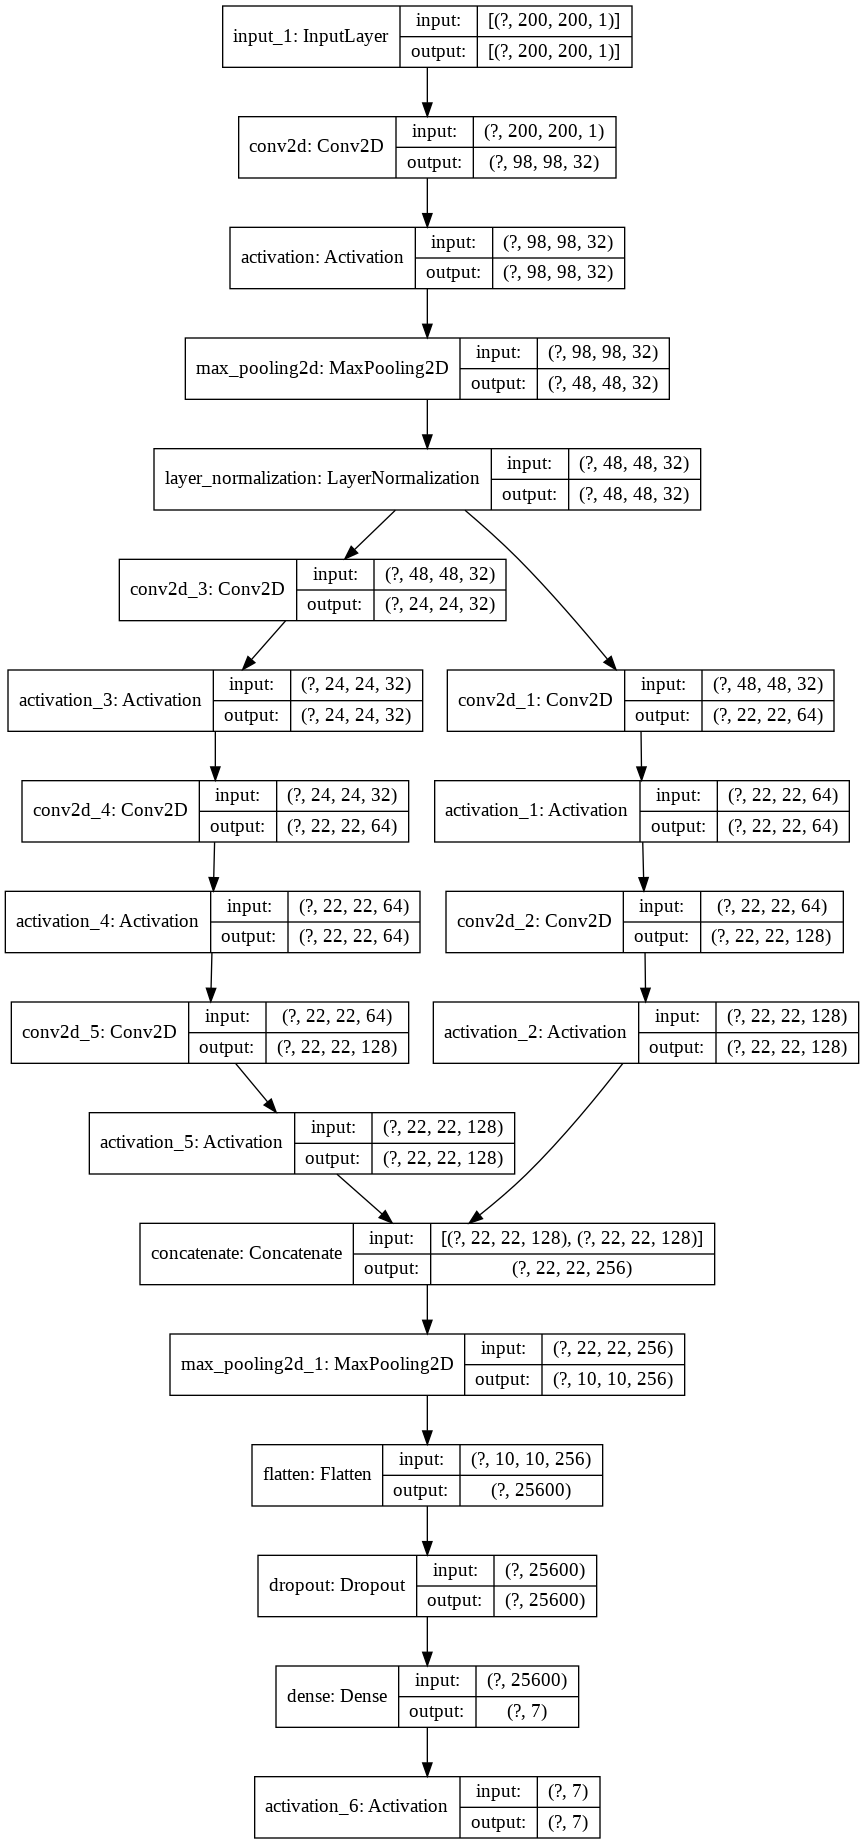

In [0]:
tf.keras.utils.plot_model(model, to_file='model_simple_kd_bw.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_d = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

tensorboard_d = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

checkpointer_d = tf.keras.callbacks.ModelCheckpoint('model_simple_kd_bw.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
history = model.fit(train_generator,
    steps_per_epoch=int(660/66),
    epochs = 150,
    shuffle=True, 
    validation_data=validation_generator,
    validation_steps=int(140/20),
    callbacks=[lr_reducer_d, tensorboard_d, early_stopper_d, checkpointer_d]
)

Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 2.2706 - accuracy: 0.1591 
Epoch 00001: val_loss improved from inf to 1.95125, saving model to model_simple_kd_bw.h5
10/10 [==============================] - 673s 67s/step - loss: 2.2706 - accuracy: 0.1591 - val_loss: 1.9513 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 1.9511 - accuracy: 0.1500
Epoch 00002: val_loss improved from 1.95125 to 1.94173, saving model to model_simple_kd_bw.h5
10/10 [==============================] - 1s 143ms/step - loss: 1.9511 - accuracy: 0.1500 - val_loss: 1.9417 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 3/150
10/10 [==============================] - ETA: 0s - loss: 1.9386 - accuracy: 0.1985
Epoch 00003: val_loss improved from 1.94173 to 1.92544, saving model to model_simple_kd_bw.h5
10/10 [==============================] - 1s 137ms/step - loss: 1.9386 - accuracy: 0.1985 - val_loss: 1.9254 - val_accuracy: 0.3286 - lr: 0.0010
Epoc

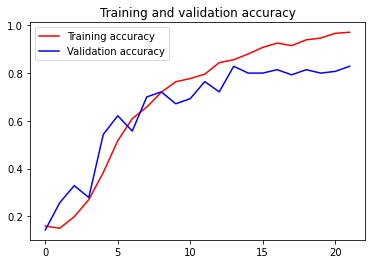

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

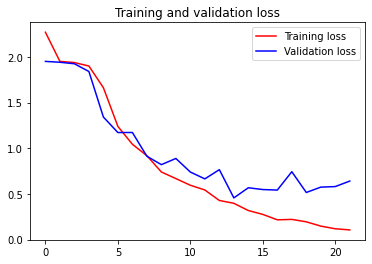

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Text(0.5, 1.0, 'Accuracy Curves')

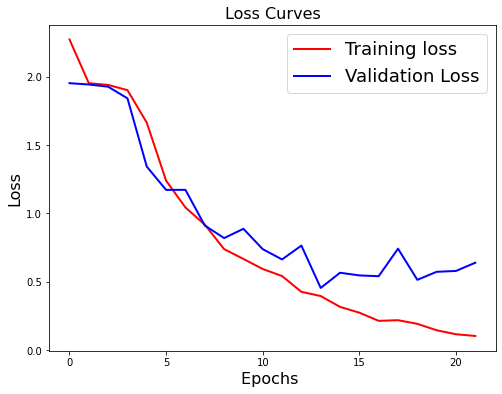

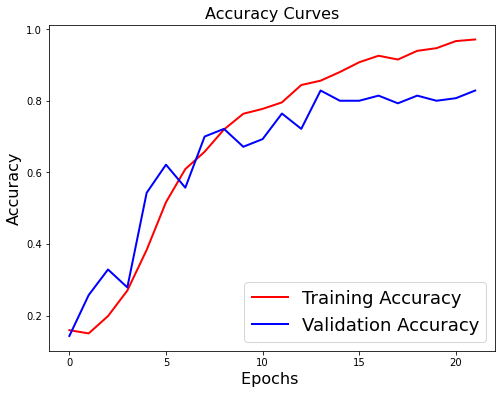

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [0]:
def detect_face(image):
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(image, minNeighbors=6,
                                                minSize=(10,10)
  )
  sub = gray

  for x, y, w, h in detected_faces:
    #if w>100:
      sub = gray[y:y+h,x:x+w]
  return sub,detected_faces

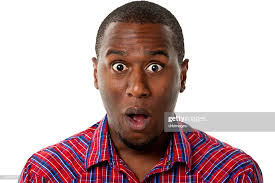

(183, 275, 3)
(99, 99)


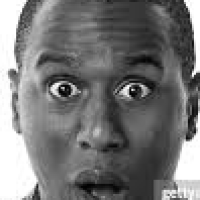

(200, 200)
(1, 200, 200, 1)


In [0]:
image = cv2.imread('/content/drive/My Drive/Datasets/sample_images/person_su3.jpg',1)
cv2_imshow(image)
print(image.shape)
sub_img,detected_face = detect_face(image)
print(sub_img.shape)
sub_img = cv2.resize(sub_img, (200,200), interpolation = cv2.INTER_AREA)
cv2_imshow(sub_img)
print(sub_img.shape)
sub_img = np.reshape(sub_img, (1,200,200,1))
print(sub_img.shape)

In [0]:
pred_array = model.predict(sub_img)
prediction = np.argmax(pred_array)
print(pred_array)
print(prediction)
if (prediction == 0):
  print('angry')
elif (prediction == 1):
  print('disgust')
elif (prediction == 2):
  print('fear')
elif (prediction == 3):
  print('happiness')
elif (prediction == 4):
  print('neutral')
elif (prediction == 5):
  print('sadness')
elif (prediction == 6):
  print('surprise')

[[0.00887656 0.00912129 0.01046005 0.09989724 0.5907771  0.00365924
  0.2772085 ]]
4
neutral


In [0]:
score= model.evaluate_generator(test_generator,verbose=1,steps=15)

Instructions for updating:
Please use Model.evaluate, which supports generators.
15/15 [==============================] - 128s 9s/step - loss: 0.5097 - accuracy: 0.8322
